Non-Stacked


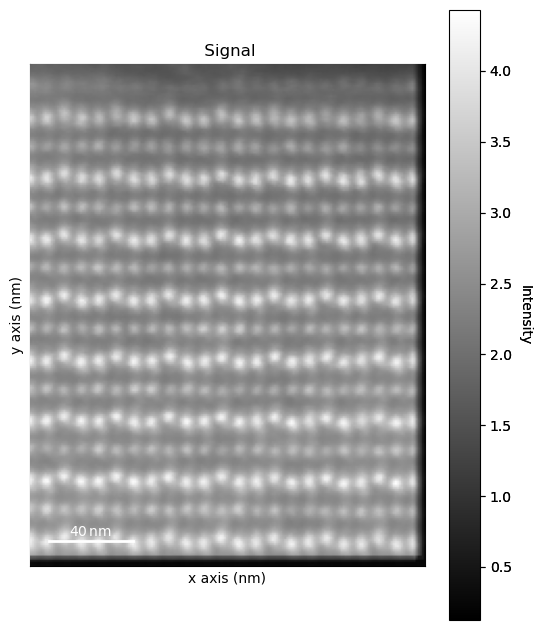

In [60]:
import skimage
import matplotlib.pyplot as plt
import hyperspy.api as hs
import sys
sys.path.append('../..')
import util.crop

stack_num = 0 # The index of stacked image

# Change the name of s_load to load different plots.
# Note that some datasets are in stacks and their data will be 3-dimension,
# where the first dimention is the index of a single stacked image. We want to
# look at one image each of the time, so for those stacked images, please change
# stack_num to view different images.

# Load one file at a time.
# These commented files are some that I want think could be reevaluated later for references.
# s_load = hs.load('../../data/images/Jaume LFO/HAADF_Buena.dm3')
s_load = hs.load('../../data/images/Jaume LFO EELS/EEL SI 22 13/Integrated Shifted Spectrum Image adf.dm3')

if len(s_load.data.shape) == 2: # Non-stacked
    print("Non-Stacked")
    s = s_load
else: # Stacked, where s_load.data.shape = 3
    print("Stacked")
    s = s_load.inav[stack_num]

# Plot the image in pixels. We can plot in nanometers by simply doing s.plot().
import copy
s_copy = copy.deepcopy(s)
for ax in s_copy.axes_manager.signal_axes:
    ax.scale = 1.0
    ax.offset = 0.0

plt.close()
s_copy.plot()

In [61]:
import scipy.signal
import numpy as np

# left_bound = 100 # TUNE
# right_bound = 2048-100 # TUNE THIS
# start_pixel = 100 # TUNE THIS
# end_pixel = 2048-100 # TUNE THIS THIS

left_bound = 0 # TUNE THIS
right_bound = 185 # TUNE THIS
start_pixel = 20 # TUNE THIS
end_pixel = 235 # TUNE THIS

crop = util.crop.Crop(s, left_bound, right_bound, start_pixel, end_pixel)

In [62]:
crop.build_grid_dict()
crop.get_atom_positions()
# crop.refine_atom_positions()

crop.get_nn_intensities()
crop.get_nn_displacements()
crop.get_atom_types()

In [63]:
from sklearn.decomposition import PCA

def get_intensity_pca(crop, atom_type='Lu', n_components=4):

    intensity_vectors = []
    for patch in crop.grid.values():
        if patch.nn_intensity_differences is not None and patch.atom_type == atom_type:
            intensity_vectors.append(patch.nn_intensity_differences)

    X = np.array(intensity_vectors)
    pca = PCA(n_components=n_components) 
    pca.fit(X)
    scores = pca.transform(X)
    return X, pca, scores

def plot_pca_vectors(pca):
    feature_names = ['up', 'down', 'left', 'right']
    fig, axes = plt.subplots(2, 2, figsize=(9, 6), sharey=True)
    axes = axes.flatten()

    for i in range(pca.n_components):
        ax = axes[i]
        components = pca.components_[i]
        ax.bar(feature_names, components)
        ax.set_title(f'PC {i+1} (Explains {pca.explained_variance_ratio_[i]:.1%} var)')
        ax.set_ylabel('Component Loading')
        ax.axhline(0, color='black', linewidth=0.8, linestyle='--')

    plt.tight_layout()
    plt.show()

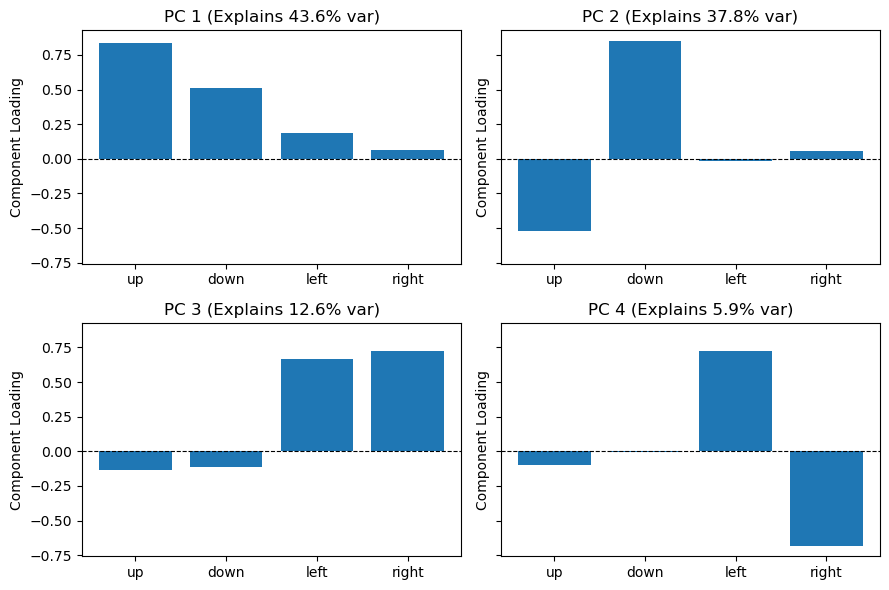

In [64]:
X, pca, scores = get_intensity_pca(crop, atom_type='Lu', n_components=4)
plot_pca_vectors(pca)

Simply looking at the intensity, PC3 specifically explains our intended intensity differences.

In [65]:
import matplotlib.colors as mcolors
from matplotlib.patches import Rectangle

def get_edges(patch):
        col_edges = patch.roi_col_edges
        row_edges = patch.roi_row_edges
        x0, x1 = float(col_edges[0]), float(col_edges[1])
        y0, y1 = float(row_edges[0]), float(row_edges[1])
        return x0, x1, y0, y1

def get_patch_score_map(crop, pca, atom_type='Lu'):
    valid_patches = []
    for patch in crop.grid.values():
        if (patch.nn_intensity_differences is not None 
            and patch.atom_type == atom_type):
            valid_patches.append(patch)
    
    scores = pca.fit_transform(X)
    patch_score_map = {patch: score for patch, score in zip(valid_patches, scores)}
    return patch_score_map

def plot_pca_grid(crop, pca, pc_component, atom_type='Lu'):
    one_idx_pc = pc_component + 1 # For display purposes
    patch_score_map = get_patch_score_map(crop, pca, atom_type)
    
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(crop.roi, cmap='gray', alpha=0.5)
    max_abs = np.max(np.abs([score[pc_component] for score in patch_score_map.values()]))
    norm = mcolors.Normalize(vmin=-max_abs, vmax=max_abs)
    cmap = plt.get_cmap('bwr')

    def _draw_box(patch, color, fill, z):
        edges = get_edges(patch)
        if edges is None: return
        x0, x1, y0, y1 = edges
        wr = x1 - x0
        hr = y1 - y0
        rect = Rectangle((x0, y0), wr, hr, edgecolor=color, facecolor=color, 
                         fill=fill, linewidth=1, alpha=0.8, zorder=z)
        ax.add_patch(rect)

    for patch in patch_score_map:
        score = patch_score_map[patch][pc_component]
        color = cmap(norm(score))
        _draw_box(patch, color=color, fill=True, z=2)

    explained_var = pca.explained_variance_ratio_[pc_component]
    ax.set_title(f'Spatial Map of PC {one_idx_pc} (Explains {explained_var:.1%} var)\nAtom Type: {atom_type}')
    
    # Add Colorbar
    sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, shrink=0.8)
    cbar.set_label(f'PC {one_idx_pc} Score (Deviation from Mean)')

    ax.set_xlabel('i (x)')
    ax.set_ylabel('j (y)')
    plt.tight_layout()
    plt.show()

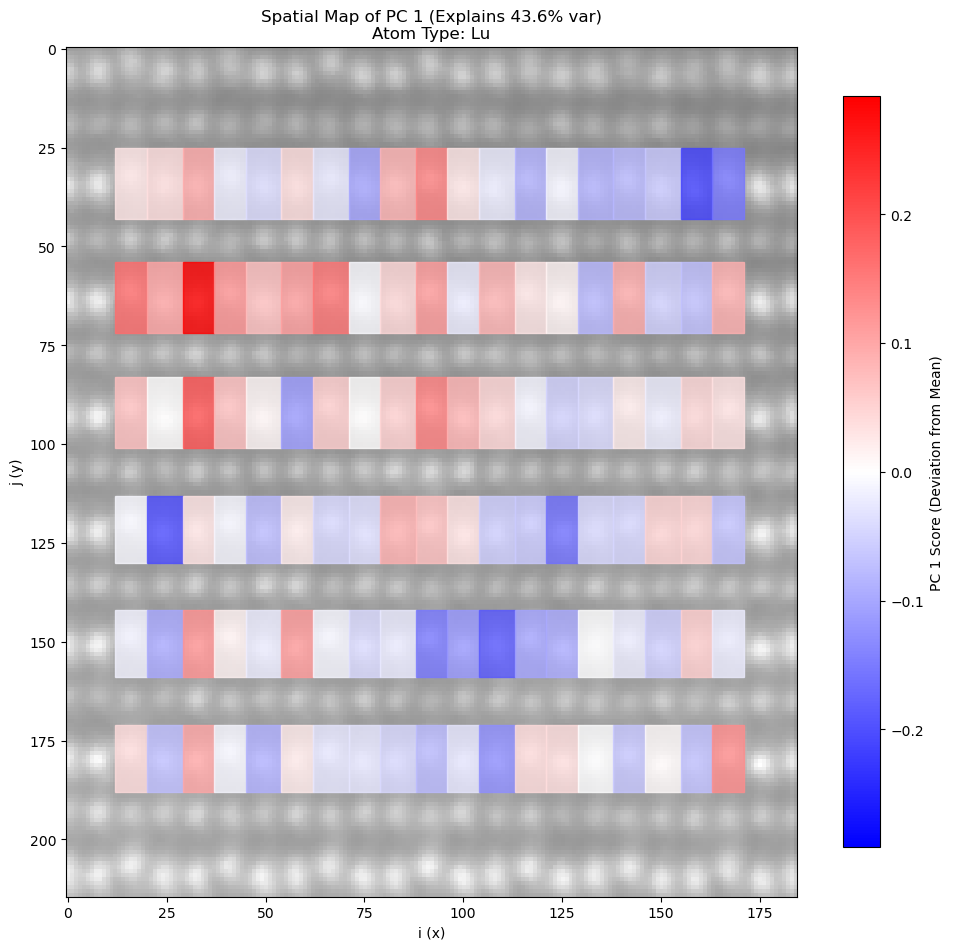

In [66]:
plot_pca_grid(crop, pca, pc_component=0, atom_type='Lu')

In [8]:
def plot_indexed_patches(crop, patch):
    if patch.nn_intensity_differences is None:
        print("The patch at the given indices does not have valid nn_intensity_differences.")
        return

    i, j = patch.index
    up_bound = crop.grid[i, j-1].roi_row_edges[0]
    low_bound = crop.grid[i, j+1].roi_row_edges[1]
    left_bound = crop.grid[i-1, j].roi_col_edges[0]
    right_bound = crop.grid[i+1, j].roi_col_edges[1]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(crop.roi.isig[left_bound:right_bound, up_bound:low_bound], cmap='gray')
    ax.set_title(f'Highlighted Patches by Indices')
    ax.set_xlabel('i (x)')
    ax.set_ylabel('j (y)')
    plt.tight_layout()
    plt.show()

In [37]:
term = 'LuFe'
batch = f'test_{term}'
total = 40
layer = 5
path = f"../../data/simulations/{batch}/{term}_layer{layer}_total{total}.npy"
s_sim = hs.load(path)
crop_sim = util.crop.Crop(s_sim)

crop_sim.build_grid_dict()
crop_sim.get_atom_positions()
# crop_sim.refine_atom_positions()

crop_sim.get_nn_intensities()
crop_sim.get_nn_displacements()
crop_sim.get_atom_types()

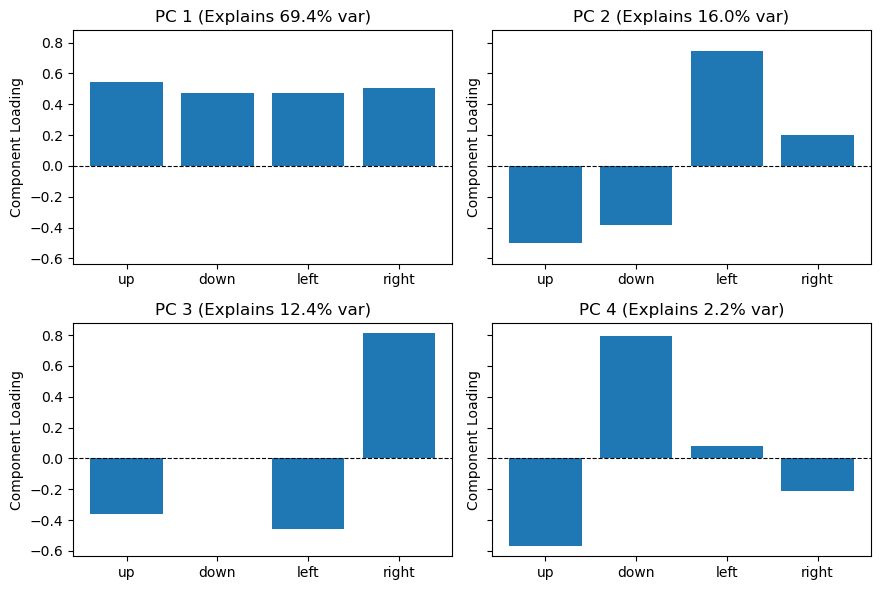

In [44]:
X, pca, scores = get_intensity_pca(crop_sim, atom_type='Fe', n_components=4)
plot_pca_vectors(pca)

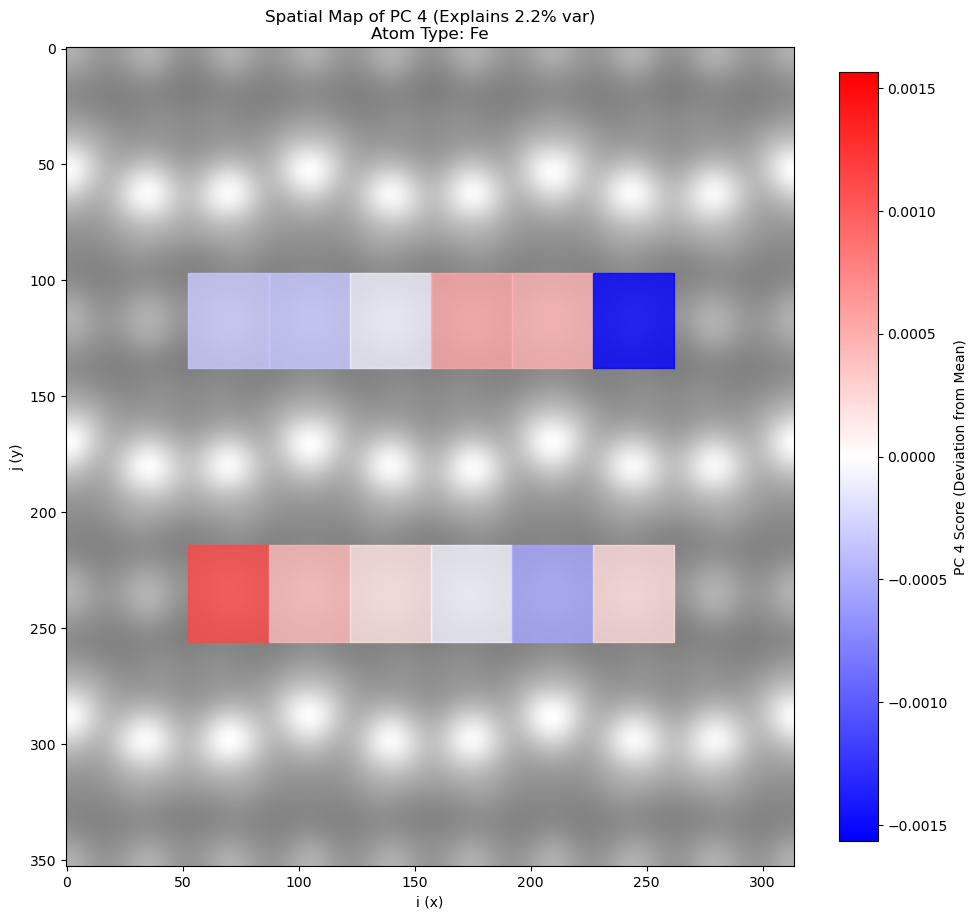

In [49]:
plot_pca_grid(crop_sim, pca, pc_component=3, atom_type='Fe')